In [1]:
from torch.utils.data import DataLoader
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_squared_error
import pytorch_lightning as pl
import torch
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from lightning.pytorch.core.module import LightningModule
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
from IPython.display import display
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.loggers.csv_logs import CSVLogger
from coral_pytorch.losses import corn_loss
from coral_pytorch.dataset import corn_label_from_logits
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score


In [2]:
dataset = load_dataset("kamel-usp/aes_enem_dataset", "sourceAWithGraders", cache_dir="/tmp/aes_enem")

In [30]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'id_prompt', 'prompt', 'supporting_text', 'essay_title', 'essay_text', 'grades', 'essay_year', 'general_comment', 'specific_comment', 'reference', 'label'],
        num_rows: 758
    })
    validation: Dataset({
        features: ['id', 'id_prompt', 'prompt', 'supporting_text', 'essay_title', 'essay_text', 'grades', 'essay_year', 'general_comment', 'specific_comment', 'reference', 'label'],
        num_rows: 198
    })
    test: Dataset({
        features: ['id', 'id_prompt', 'prompt', 'supporting_text', 'essay_title', 'essay_text', 'grades', 'essay_year', 'general_comment', 'specific_comment', 'reference', 'label'],
        num_rows: 209
    })
    test_easy: Dataset({
        features: ['id_prompt', 'id', 'is_hard', 'prompt', 'supporting_text', 'essay_title', 'essay_text', 'grades', 'essay_year', 'general_comment', 'specific_comment', 'reference', 'label', '__index_level_0__'],
        num_rows: 167
    })
    test_hard: Dat

In [3]:
REFERENCE_CONCEPT = 0

In [4]:
grade_mapping = {
    0: 0,
    40: 1,
    80: 2,
    120: 3,
    160: 4,
    200: 5,
     2: 0,
}

def create_label(row):
    grade = row["grades"][REFERENCE_CONCEPT]
    return {"label": grade_mapping[grade]}

dataset = dataset.map(create_label)

## BErt

In [5]:
RANDOM_SEED = 42
REFERENCE_CONCEPT = 3
MAX_LENGTH = 256
BATCH_SIZE=16
WEIGHT_DECAY=0.01
GRADIENT_ACC = 1
LEARNING_RATE = 1e-4

OBJECTIVE = "regression"
PRECISION = "16-mixed"
VARIANT = "large"
BASE_MODEL = "bertimbau"

TOKENIZER_NAME = f"neuralmind/bert-{VARIANT}-portuguese-cased"
MODEL_NAME = f"neuralmind/bert-{VARIANT}-portuguese-cased"
EXPERIMENT_NAME = f"aes_enem_models-sourceA-{OBJECTIVE}-from-{BASE_MODEL}-{VARIANT}-C{REFERENCE_CONCEPT+1}"

pl.seed_everything(RANDOM_SEED)
torch.set_float32_matmul_precision('medium')

Seed set to 42


In [6]:
def compute_difference(lists):
    # Assuming the first element is the reference for subtraction
    reference = lists[0][REFERENCE_CONCEPT]
    if len(lists) >= 3:
      grader_a = lists[1][REFERENCE_CONCEPT]
      grader_b = lists[2][REFERENCE_CONCEPT]

      # Calculate absolute differences
      diff_ref_a = abs(reference - grader_a)
      diff_ref_b = abs(reference - grader_b)
      diff_a_b = abs(grader_a - grader_b)

      # Check if any difference is greater than 80
      return diff_ref_a > 80 or diff_ref_b > 80 or diff_a_b > 80
    else:
        # Handle cases where there are not enough graders
        # You might want to return False (not hard) or raise a warning
        return False
test_df = dataset["test"].to_pandas()
new_test_df = pd.merge(
    test_df.groupby(["id_prompt", "id"]).agg({"grades": list}).apply(lambda x: compute_difference(x['grades']), axis=1).reset_index(),
    test_df,
    on=["id_prompt","id"]
).rename(columns={0: "is_hard"})

In [7]:
dataset["test_easy"] = Dataset.from_pandas(new_test_df[new_test_df["is_hard"]==False])
dataset["test_hard"] = Dataset.from_pandas(new_test_df[new_test_df["is_hard"]==True])

In [8]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
def get_model_instance(model_path, objective):
    model = None
    if objective == "regression":
        model = AutoModelForSequenceClassification.from_pretrained(
                model_path,
                cache_dir="/tmp/",
                num_labels=1,
            )
    elif objective == "classification" or objective == "ordinal":
        model = AutoModelForSequenceClassification.from_pretrained(
                model_path,
                cache_dir="/tmp/",
                num_labels=6,
            )
    return model
model = get_model_instance(MODEL_NAME, OBJECTIVE)
if model is None:
    raise ValueError("Please set a Pre defined Objectice")

/home/nathan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def prepare_dataset(dataset):
    def tokenize_essays(dataset, tokenizer, max_length=512):
        tokenized_text = tokenizer(
                dataset["essay_text"],
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
        tokenized_text["label"] = dataset["label"]
        return tokenized_text

    tokenized_datasets = {
        split: tokenize_essays(sub_dataset, tokenizer, MAX_LENGTH)
        for split, sub_dataset in dataset.items()
    }
    dataset_tokenized = DatasetDict({
        split: Dataset.from_dict(data)
        for split, data in tokenized_datasets.items()
    })

    return dataset_tokenized

dataset_tokenized = prepare_dataset(dataset)

In [10]:
data_train = DataLoader(
    dataset_tokenized["train"].with_format("torch"), batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
data_val = DataLoader(dataset_tokenized["validation"].with_format("torch"), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
data_test = DataLoader(dataset_tokenized["test"].with_format("torch"), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

data_test_easy = DataLoader(dataset_tokenized["test_easy"].with_format("torch"), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
data_test_hard = DataLoader(dataset_tokenized["test_hard"].with_format("torch"), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [11]:
def predict_classes(output):
    if OBJECTIVE == "regression":
        # Round the tensor to the nearest integer
        rounded_tensor = torch.round(output.logits)
        # Clamp the values to the range [0, 5]
        clamped_tensor = torch.clamp(rounded_tensor, min=0, max=5)
        return clamped_tensor.view(-1)
    elif OBJECTIVE == "classification":
        return torch.argmax(output.logits, axis=1)
    elif OBJECTIVE == "ordinal":
        return corn_label_from_logits(output.logits)

def get_predictions_and_labels(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_predictions = []
    all_true_labels = []
    i=0
    for batch in tqdm(dataloader, desc="Obtaining predictions"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        with torch.no_grad():
            output = model(input_ids, attention_mask)
            predicted_classes = predict_classes(output)

        # If using GPU, need to move the data back to CPU to use numpy.
        all_predictions.extend(predicted_classes.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

    return list(map(lambda x: x * 40, all_predictions)), list(map(lambda x: x * 40, all_true_labels))

all_predictions, all_true_labels = get_predictions_and_labels(model, data_val)

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
def enem_accuracy_score(true_values, predicted_values):
    assert len(true_values) == len(predicted_values), "Mismatched length between true and predicted values."

    non_divergent_count = sum([1 for t, p in zip(true_values, predicted_values) if abs(t - p) <= 80])

    return non_divergent_count / len(true_values)

In [13]:
accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Accuracy on the validation  set: {accuracy:.2f}")

Accuracy on the validation  set: 0.01


In [14]:
qwk = cohen_kappa_score(all_true_labels, all_predictions, weights="quadratic", labels=[0,40,80,120,160,200])
print(f"QWK on the validation set: {qwk:.2f}")

QWK on the validation set: -0.02


In [15]:
enem_accuracy = enem_accuracy_score(all_true_labels, all_predictions)
print(f"Accuracy on the validation set: {enem_accuracy:.2f}")

Accuracy on the validation set: 0.37


In [16]:
class LightningGradePredictor(LightningModule):
    def __init__(self, model: nn.Module, loss_function, learning_rate=0.001, num_warmup_steps=None, num_training_steps=None):
        super(LightningGradePredictor, self).__init__()
        self.model = model
        self.loss = loss_function
        self.learning_rate = learning_rate
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.save_hyperparameters(ignore=['model'])
        self.training_step_loss = []
        self.validation_step_loss = []

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch["input_ids"], batch["attention_mask"], batch["label"]
        outputs = self(input_ids, attention_mask)
        loss = None
        if OBJECTIVE == "regression":
            loss = self.loss(outputs.logits, labels.unsqueeze(1).float())
        elif OBJECTIVE == "classification":
            loss = self.loss(outputs.logits, labels)
        elif OBJECTIVE == "ordinal":
            loss = self.loss(outputs.logits, labels, num_classes=self.model.num_labels)
        self.log('train_loss', loss)
        self.training_step_loss.append(loss)
        optimizer = self.optimizers()
        if isinstance(optimizer, list):
            optimizer = optimizer[0]
        lr_current = optimizer.optimizer.param_groups[0]['lr']
        self.log('current_lr', lr_current)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch["input_ids"], batch["attention_mask"], batch["label"]
        outputs = self(input_ids, attention_mask)
        if OBJECTIVE == "regression":
            loss = self.loss(outputs.logits, labels.unsqueeze(1).float())
        elif OBJECTIVE == "classification":
            loss = self.loss(outputs.logits, labels)
        elif OBJECTIVE == "ordinal":
            loss = self.loss(outputs.logits, labels, num_classes=self.model.num_labels)
        self.log('val_loss', loss)
        self.validation_step_loss.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch["input_ids"], batch["attention_mask"], batch["label"]
        outputs = self(input_ids, attention_mask)
        if OBJECTIVE == "regression":
            loss = self.loss(outputs.logits,  labels.unsqueeze(1).float())
        elif OBJECTIVE == "classification":
            loss = self.loss(outputs.logits, labels)
        elif OBJECTIVE == "ordinal":
            loss = self.loss(outputs.logits, labels, num_classes=self.model.num_labels)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=WEIGHT_DECAY)

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [17]:
class EpochEndCallback(Callback):
    def __init__(self):
        self.metrics_df = pd.DataFrame(columns=
                                       ['Epoch', 'Train Loss', 'Validation Loss',
                                         'Train QWK', 'Validation QWK',
                                         'Train RMSE', 'Validation RMSE'
                                        ])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def on_train_epoch_end(self, trainer, pl_module):
        current_epoch = trainer.current_epoch
        # Metrics for training data
        train_dataloader = trainer.train_dataloader
        val_dataloader = trainer.val_dataloaders

        epoch_train_loss_mean = torch.stack(pl_module.training_step_loss).mean()
        epoch_val_loss_mean = torch.stack(pl_module.validation_step_loss).mean()
        pl_module.training_step_loss.clear()
        pl_module.validation_step_loss.clear()
        model.eval()
        train_predictions, train_true_labels = get_predictions_and_labels(model, train_dataloader)
        val_predictions, val_true_labels = get_predictions_and_labels(model, val_dataloader)
        train_qwk = cohen_kappa_score(train_true_labels, train_predictions, weights="quadratic", labels=[0,40,80,120,160,200])
        val_qwk = cohen_kappa_score(val_true_labels, val_predictions, weights="quadratic", labels=[0,40,80,120,160,200])
        pl_module.log('val_qwk', val_qwk)

        train_rmse = mean_squared_error(train_true_labels, train_predictions)
        val_rmse = mean_squared_error(val_true_labels, val_predictions)
        train_rmse = np.sqrt(train_rmse)
        val_rmse = np.sqrt(val_rmse)
        pl_module.log('val_rmse', val_rmse)

        new_row = {'Epoch': current_epoch,
                    'Train Loss': epoch_train_loss_mean.cpu().detach().numpy(),
                    'Validation Loss': epoch_val_loss_mean.cpu().detach().numpy(),
                    'Train QWK': train_qwk,
                    'Validation QWK': val_qwk,
                    'Train RMSE': train_rmse,
                    'Validation RMSE': val_rmse
                    }
        new_row = pd.Series(new_row).to_frame().T
        self.metrics_df = pd.concat([self.metrics_df, new_row])
        display(self.metrics_df)

In [18]:
early_stop_callback = EarlyStopping(monitor="val_qwk", patience=3, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_qwk", mode="max")

In [19]:
def get_loss():
    if OBJECTIVE == "regression":
        return torch.nn.functional.mse_loss
    elif OBJECTIVE == "classification":
        return torch.nn.functional.cross_entropy
    elif OBJECTIVE == "ordinal":
        return corn_loss

loss_function = get_loss()
NUM_EPOCHS = 20
num_training_steps = NUM_EPOCHS * len(data_train)
warmup_steps = int(num_training_steps * 0.1)
steps_per_epoch = num_training_steps//NUM_EPOCHS
model.train()
trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    log_every_n_steps=steps_per_epoch,
    logger=CSVLogger("model_logs", name=EXPERIMENT_NAME),
    callbacks=[EpochEndCallback(), early_stop_callback, checkpoint_callback],
    precision=PRECISION,
    accumulate_grad_batches=GRADIENT_ACC
    )
ligthning_model = LightningGradePredictor(model,
                    loss_function=loss_function,
                    num_training_steps=num_training_steps,
                    num_warmup_steps=warmup_steps,
                    learning_rate = LEARNING_RATE
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model=ligthning_model, train_dataloaders=data_train, val_dataloaders=data_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 334 M 
--------------------------------------------------------
334 M     Trainable params
0         Non-trainable params
334 M     Total params
1,337.590 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nathan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/home/nathan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/nathan/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815


Metric val_qwk improved. New best score: 0.469


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791


Metric val_qwk improved by 0.013 >= min_delta = 0.0. New best score: 0.481


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791
0,3,0.9535805,0.8198501,0.593221,0.395957,35.528427,38.349799


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791
0,3,0.9535805,0.8198501,0.593221,0.395957,35.528427,38.349799
0,4,0.85810536,0.7454878,0.690601,0.49117,33.604875,37.281349


Metric val_qwk improved by 0.010 >= min_delta = 0.0. New best score: 0.491


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791
0,3,0.9535805,0.8198501,0.593221,0.395957,35.528427,38.349799
0,4,0.85810536,0.7454878,0.690601,0.49117,33.604875,37.281349
0,5,0.7585864,0.7512756,0.710665,0.452705,32.810321,37.281349


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791
0,3,0.9535805,0.8198501,0.593221,0.395957,35.528427,38.349799
0,4,0.85810536,0.7454878,0.690601,0.49117,33.604875,37.281349
0,5,0.7585864,0.7512756,0.710665,0.452705,32.810321,37.281349
0,6,0.7514595,0.83946055,0.67997,0.423191,33.573454,39.593898


Validation: |          | 0/? [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train QWK,Validation QWK,Train RMSE,Validation RMSE
0,0,3.0870695,1.9577413,0.538223,0.468694,38.685526,37.172815
0,1,1.0176003,1.1546949,0.513953,0.302074,39.628885,45.660141
0,2,2.2213035,0.79214495,0.610778,0.48145,36.292567,36.954791
0,3,0.9535805,0.8198501,0.593221,0.395957,35.528427,38.349799
0,4,0.85810536,0.7454878,0.690601,0.49117,33.604875,37.281349
0,5,0.7585864,0.7512756,0.710665,0.452705,32.810321,37.281349
0,6,0.7514595,0.83946055,0.67997,0.423191,33.573454,39.593898
0,7,0.6953604,0.8049829,0.715649,0.419195,32.713678,39.389277


Monitored metric val_qwk did not improve in the last 3 records. Best score: 0.491. Signaling Trainer to stop.


In [21]:
best_model = LightningGradePredictor.load_from_checkpoint(checkpoint_callback.best_model_path,
                                                  model=ligthning_model.model,
                                                  loss_function=ligthning_model.loss)
best_model.model.eval()
all_predictions, all_true_labels = get_predictions_and_labels(best_model.model, data_val)
rmse_val = mean_squared_error(all_true_labels, all_predictions, squared=False)
print(f"RMSE on the validation set: {rmse_val: .4f}")

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

RMSE on the validation set:  37.2813


In [22]:
def compute_metrics(model, dataset, test_group):
    all_predictions, all_true_labels = get_predictions_and_labels(model, dataset)
    accuracy = accuracy_score(all_true_labels, all_predictions)
    qwk = cohen_kappa_score(all_true_labels, all_predictions, weights="quadratic", labels=[0,40,80,120,160,200])
    rmse = mean_squared_error(all_true_labels, all_predictions, squared=False)
    horizontal_discrepancy = enem_accuracy_score(all_true_labels, all_predictions)
    result = {
        'Experiment Reference': EXPERIMENT_NAME,
        'Test Group': test_group,
        'Competence': REFERENCE_CONCEPT,
        'Accuracy': [accuracy],
        'RMSE': [rmse],
        'QWK': [qwk],
        'HDIV': [1- horizontal_discrepancy]
    }
    return pd.DataFrame(result)

In [23]:
compute_metrics(best_model.model, data_val, 'validation')

Obtaining predictions:   0%|          | 0/13 [00:00<?, ?it/s]

,Experiment Reference,Test Group,Competence,Accuracy,RMSE,QWK,HDIV
0,aes_enem_models-sourceA-regression-from-bertim...,validation,3,0.459596,37.281349,0.49117,0.020202


In [24]:
def generate_report(model, data_test, data_test_easy, data_test_hard):
    result = pd.concat([
        compute_metrics(model, data_test, "full"),
        compute_metrics(model, data_test_easy, "easy"),
        compute_metrics(model, data_test_hard, "hard")
    ])
    directory = "experiment_reports"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = f"{directory}/{EXPERIMENT_NAME}.csv"
    file_exists = os.path.isfile(file_path) and os.path.getsize(file_path) > 0
    if file_exists:
        result.to_csv(file_path, mode='a', header=False, index=False)
    else:
        result.to_csv(file_path, mode='w', header=True, index=False)
    return result

In [25]:
generate_report(best_model.model, data_test, data_test_easy, data_test_hard)

Obtaining predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/11 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/3 [00:00<?, ?it/s]

,Experiment Reference,Test Group,Competence,Accuracy,RMSE,QWK,HDIV
0,aes_enem_models-sourceA-regression-from-bertim...,full,3,0.535885,41.502868,0.436077,0.052632
0,aes_enem_models-sourceA-regression-from-bertim...,easy,3,0.550898,32.463706,0.556087,0.005988
0,aes_enem_models-sourceA-regression-from-bertim...,hard,3,0.476190,66.188763,0.116356,0.238095


In [26]:
bert_save_path = f"model_checkpoints/hugging_face/finetuning/{EXPERIMENT_NAME}"
bert_save_path

'model_checkpoints/hugging_face/finetuning/aes_enem_models-sourceA-regression-from-bertimbau-large-C4'

In [27]:
best_model.model.save_pretrained(bert_save_path)

In [28]:
model = get_model_instance(bert_save_path, OBJECTIVE)
compute_metrics(model, data_test, "full")

Obtaining predictions:   0%|          | 0/14 [00:00<?, ?it/s]

,Experiment Reference,Test Group,Competence,Accuracy,RMSE,QWK,HDIV
0,aes_enem_models-sourceA-regression-from-bertim...,full,3,0.535885,41.502868,0.436077,0.052632


Obtaining predictions:   0%|          | 0/14 [00:00<?, ?it/s]

classification:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
        40.0       0.00      0.00      0.00         0
        80.0       0.45      0.35      0.39        37
       120.0       0.64      0.56      0.60       100
       160.0       0.68      0.60      0.64        72
       200.0       0.00      0.00      0.00         0

    accuracy                           0.54       209
   macro avg       0.30      0.25      0.27       209
weighted avg       0.62      0.54      0.58       209




/home/nathan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nathan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nathan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


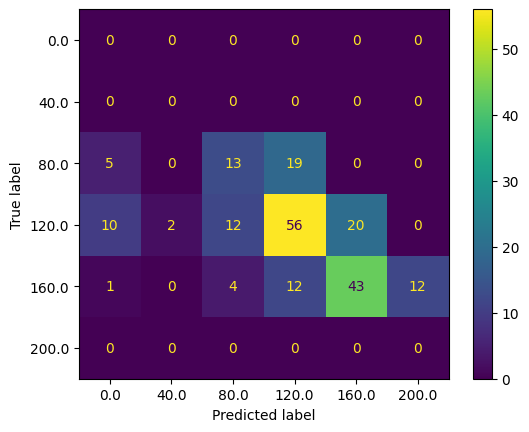

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
all_predictions,all_true_labels = get_predictions_and_labels(model,data_test)
report = classification_report(all_predictions, all_true_labels)
print(f"classification: {report}\n")
ConfusionMatrixDisplay.from_predictions(all_predictions,all_true_labels)